<a href="https://colab.research.google.com/github/anonymous-code-submission/ICML2021_anonymous_code_submission/blob/main/cutting_planes_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anonymous code submission for the ICML 2021 paper *What does a deep neural network confidently perceive? The effective dimension of high certainty class manifolds and their low confidence boundaries*

This Colab demonstrates the core experiment of the ICML 2021 submission *What does a deep neural network confidently perceive? The effective dimension of high certainty class manifolds and their low confidence boundaries*. It trains a model from scratch for a few epochs, conducts input space partitioning experiments using random hyperplanes, and calculates the effective dimension $d^*_{50\%}$  for the class manifolds for each of the CIFAR-10 classes.

This is an **anonymous code submission** that will be deanonymized after the ICML 2021 review period ends.

The notebook will train a ResNet20v1 on CIFAR-10 for a few epochs and perform our core cutting plane experiment for each single class manifold using a sweep of cutting plane dimensions $d$, each repeated 5 times. You should be able to run this from scratch on a free Google Colab GPU in less than 5 minutes. The resulting figure will look like this:

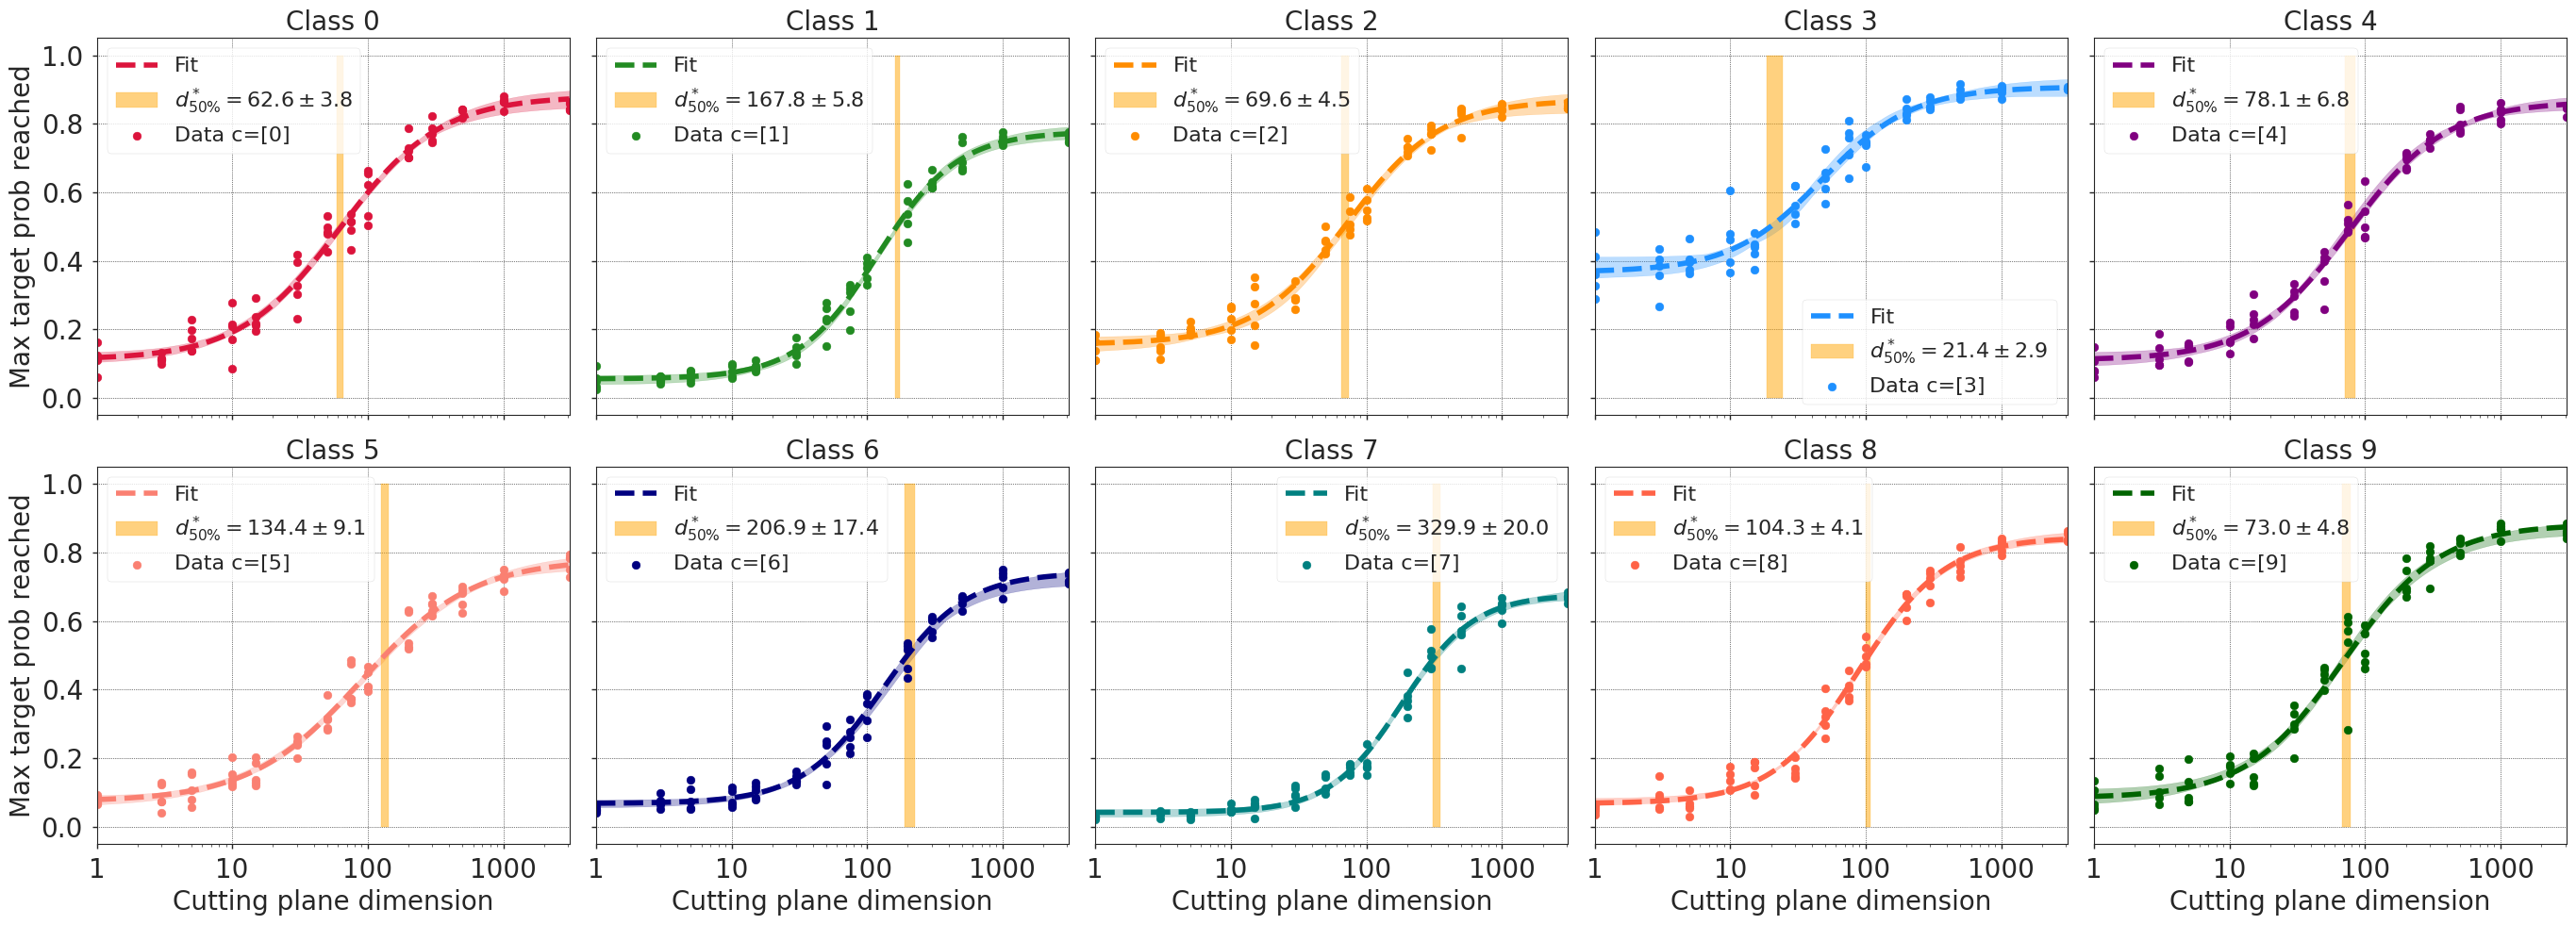


# Loading libraries

In [1]:
#@title
!pip install flax

     |████████████████████████████████| 163kB 13.7MB/s 


# Libraries

In [2]:
#@title
import jax

jax.config.enable_omnistaging()

import flax

import numpy as onp #original numpy
import jax.numpy as jnp #jax numpy

import tensorflow_datasets as tfds

from jax.experimental import optimizers
from flax import nn

import math
import time

import jax.ops as ops
import jax.random as random

import matplotlib.pyplot as plt

# Plotting style

In [3]:
#@title
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2, 
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE, 
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

# Example architectures

## Simple CNN architecture

In [4]:
class CNN(flax.nn.Module):
  def apply(self, x, classes = 10, channels = [32,64,64,128], train=False):

    for features in channels:
      x = flax.nn.Conv(x, features=features, kernel_size=(3, 3))
      x = flax.nn.relu(x)
      x = flax.nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

    #getting it flat
    x = x.reshape((x.shape[0], -1))

    # final layer
    x = flax.nn.Dense(x, features=classes)
    x = flax.nn.log_softmax(x)
    return x

## ResNets

In [5]:
class KerasResNets(flax.nn.Module): #inspired by the Keras examples and rewritten to JAX
  
  def apply(self, x, train=True, depth = (3*6+2), num_classes=10, use_batch_norm=True):

    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation="relu",
                     conv_first=True,
                     train=True,
                     ):
      
      if use_batch_norm:
        batch_norm = nn.BatchNorm.partial(use_running_average=not train,momentum=0.9, epsilon=1e-5)
      
      if activation == "relu":
        f = flax.nn.relu
      elif activation is None:
        f = lambda q: q

      a = inputs
      if conv_first:
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(3, 3))
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
      else:
        if use_batch_norm:
          a = batch_norm(a)
        a = f(a)
        a = flax.nn.Conv(a, features=num_filters,strides=(strides,strides),padding="SAME",kernel_size=(3, 3))
      
      return a

    if (depth - 2) % 6 != 0:
          raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
      
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = x
    x = resnet_layer(inputs=inputs, train=train)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters,
                            strides=strides, train=train)
            
            y = resnet_layer(inputs=y,
                            num_filters=num_filters,
                            activation=None, train=train)
            
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                num_filters=num_filters,
                                kernel_size=1,
                                strides=strides,
                                activation=None, train=train)
                
            x = x+y
            x = flax.nn.relu(x)
        num_filters *= 2

    x = flax.nn.avg_pool(x, window_shape=(8, 8), strides=(8, 8))

    x = x.reshape((x.shape[0], -1))
    x = flax.nn.Dense(x, features=num_classes)
    x = flax.nn.log_softmax(x)

    return x



# Choosing the architecture

In [6]:
classes = 10 #has to match the number of classes of the chosen dataset

#choose on of the two examples, the default is ResNet
model_choice = "ResNet"
# model_choice = "SimpleCNN"

if model_choice == "ResNet":
  model_to_use = KerasResNets.partial(
    num_classes = classes,
    use_batch_norm = True,
  )
  model_name = "ResNetBN"

elif model_choice == "SimpleCNN":
  model_to_use = CNN.partial(
    classes = classes,
  )
  model_name = "SimpleCNN"

else:
  print("Architecture "+str(model_choice)+" not found!")
  assert False

# Utils

In [7]:
#@title
from flax.training import lr_schedule

def make_lr_fun(base_lr, steps_per_epoch):  
  return lr_schedule.create_stepped_learning_rate_schedule(base_lr, steps_per_epoch,[[80, 0.01], [120, 0.001]])

default_LR = 0.1
learning_rate_fn = make_lr_fun(default_LR, int(float(50000)/float(128))) # the standard ResNet training schedule (>91% test after 200 epochs)


@jax.vmap
def cross_entropy_loss(logits, label):
  return -logits[label]

def compute_metrics(logits, labels):
  loss = jnp.mean(cross_entropy_loss(logits, labels))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return {'loss': loss, 'accuracy': accuracy}

@jax.jit
def train_step(step, optimizer, batch, state):

  def loss_fn(model):

    with flax.nn.stateful(state) as new_state: #to update the state
      logits = model(batch['image'])

    loss = jnp.mean(cross_entropy_loss(
        logits, batch['label']))
    
    params = model.params

    #for L2 penalty on the loss
    weight_penalty_params = jax.tree_leaves(params)
    weight_decay = 1e-4
    weight_l2 = sum([jnp.sum(x ** 2)
                      for x in weight_penalty_params
                      if x.ndim > 2])
    weight_penalty = weight_decay * 0.5 * weight_l2

    return loss + weight_penalty, new_state

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

  (_, new_state), grad = grad_fn(optimizer.target)

  new_optimizer = optimizer.apply_gradient(grad, learning_rate=learning_rate_fn(step))

  return new_optimizer, new_state

@jax.jit
def eval(model, eval_ds, state):
  with flax.nn.stateful(state, mutable=False):
    logits = model(eval_ds['image'], train=False)
  return compute_metrics(logits, eval_ds['label'])


def normal_loss(params, batch, train=True):
  logits = jax.nn.log_softmax(model_to_use.call(params, batch['image'], train = train))
  loss = jnp.mean(cross_entropy_loss(logits, batch['label']))
  return loss

def normal_accuracy(params,batch, train=True):
  logits = jax.nn.log_softmax(model_to_use.call(params, batch['image'], train = train))
  return jnp.mean(jnp.argmax(logits, -1) == batch['label'])


# Dataset

## Choosing dataset

In [8]:
dataset_choice = "CIFAR10"
# dataset_choice = "CIFAR100"

#additional settings for fun experiments

#for real numbers between 0 and 1 uses only a fraction of the train set
#for None uses the whole train set
train_fraction = None 

#label randomization for memorization experiments
consistently_randomize_ys = False #True makes train and test labels random


## Loading dataset

In [9]:
#@title
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10,cifar100

subtract_pixel_mean = True

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif dataset_choice == "CIFAR100":
  classes = 100
  (x_train, y_train), (x_test, y_test) = cifar100.load_data()

y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])


if train_fraction is None:
  pass
else:
  n_to_keep = int(onp.ceil(float(len(x_train))*train_fraction))
  ids_to_keep = onp.random.choice(range(len(x_train)),(n_to_keep),replace = False)
  x_train = x_train[ids_to_keep]
  y_train = y_train[ids_to_keep]
  print("train_fraction",train_fraction)
  print("x_train",x_train.shape)
  print("y_train",y_train.shape)


#consistent randomization of labels
if consistently_randomize_ys:
  print("LABEL RANDOMIZATION IS ON!!")
  y_train = onp.random.choice(range(classes),y_train.shape,replace=True)
  y_test = onp.random.choice(range(classes),y_test.shape,replace=True)

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = onp.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

orig_x_train = onp.array(x_train)
orig_y_train = onp.array(y_train)

170500096/170498071 [==============================] - 6s 0us/step


In [10]:
#@title
N_train = len(x_train)
N_test = len(x_test)

train_ds = {
  'image': orig_x_train.astype(jnp.float32),
  'label': orig_y_train.astype(jnp.int32)
}

test_ds = {
  'image': x_test.astype(jnp.float32),
  'label': y_test.astype(jnp.int32)
}

# Model training loop

## Training setup

In [11]:
points_to_collect = 1 #how many times to train
epochs = 5 #how many epochs for to train

batch_size = 128 

## The training loop

In [12]:
ts = []

# collecting train params and states
params_collected_by_iteration = [[] for _ in range(points_to_collect)]
states_collected_by_iteration = [[] for _ in range(points_to_collect)]

#which iterations to save the params at
def it_to_save_fn(it):
  return (it % 100 == 0) or (it in [0,1,2,3,4,5,6,7,8,9,10]) or ((10<it<100) and (it % 10 == 0))

for point_id in range(points_to_collect):

  with flax.nn.stateful() as init_state_raw:
    _, initial_params = model_to_use.init_by_shape(jax.random.PRNGKey(point_id+9381577432), [((128, 32, 32, 3), jnp.float32)])
    model = flax.nn.Model(model_to_use, initial_params)
    init_state = init_state_raw

  state = init_state # for the batch norm params

  optimizer = flax.optim.Momentum(learning_rate=0.1, beta=0.9).create(model) #the LR doesn't matter, it changes on every update based on the train fn

  print("Number of params = "+str(onp.sum([onp.prod(x.shape) for x in jax.tree_flatten(initial_params)[0]])))
    
  params_collected_by_iteration[point_id].append((None,initial_params))
  states_collected_by_iteration[point_id].append((None,state))

  total_it = -1
  t1 = time.time()

  while True:

    #getting a random batch
    batch_ids = onp.random.choice(range(len(train_ds["image"])),(batch_size),replace = False)
    batch = {
      "image": train_ds["image"][batch_ids],
      "label": train_ds["label"][batch_ids],
    }

    total_it = total_it + 1

    if total_it / (len(x_train)/float(batch_size)) > epochs:
      break

    #getting the update step
    optimizer,state = train_step(total_it, optimizer, batch, state)

    #getting the params out
    params_now = optimizer.target.params

    if it_to_save_fn(total_it): #collecting parameters as training progresses
      params_collected_by_iteration[point_id].append((total_it,params_now))
      states_collected_by_iteration[point_id].append((total_it,state))

    #batch loss and acc
    metrics = eval(optimizer.target, batch, state)
    loss_out = metrics["loss"]
    accuracy_out = metrics["accuracy"]

    e_float = total_it / (len(x_train)/float(batch_size))

    #looking at test set once every epoch
    if (total_it % int(len(x_train)/float(batch_size))) in [0]:  
      #test verification

      #doing the BN averaing on the test
      test_loss_out_testBN = normal_loss(params_now,test_ds)
      test_accuracy_out_testBN = normal_accuracy(params_now,test_ds)

      t2 = time.time()
      if total_it > 0:
        ts.append(t2-t1)
        t_rem_str = str(int(onp.mean(ts)*points_to_collect*epochs - onp.sum(ts)))
      else:
        t_rem_str = "TBD" 
      t1 = time.time()


      print("e="+str(e_float)+
            " it="+str(total_it)+
            " train loss="+str(loss_out)+
            " train acc="+str(accuracy_out)+
            " test loss="+str(test_loss_out_testBN)+
            " test acc="+str(test_accuracy_out_testBN)+
            " t_rem="+str(t_rem_str)
            )
      


Number of params = 293738
e=0.0 it=0 train loss=2.2966468 train acc=0.1171875 test loss=2.3450055 test acc=0.13090001 t_rem=TBD
e=0.9984 it=390 train loss=1.3077884 train acc=0.546875 test loss=1.058737 test acc=0.6158 t_rem=28
e=1.9968 it=780 train loss=0.6955109 train acc=0.734375 test loss=0.79294705 test acc=0.71940005 t_rem=21
e=2.9952 it=1170 train loss=0.6801784 train acc=0.7578125 test loss=0.7028569 test acc=0.7601 t_rem=14
e=3.9936 it=1560 train loss=0.39909375 train acc=0.828125 test loss=0.66252816 test acc=0.77440006 t_rem=7
e=4.992 it=1950 train loss=0.4385842 train acc=0.8671875 test loss=0.61109173 test acc=0.79420006 t_rem=0


# Checking the learning curves

In [13]:
test_preds = [ [] for _ in range(len(params_collected_by_iteration))]
its = [ [] for _ in range(len(params_collected_by_iteration))]

times = []

t1 = time.time()

skip = 1

for i_run in range(len(params_collected_by_iteration)):

  params_collected_now = params_collected_by_iteration[i_run]

  for i_step in list(range(len(params_collected_now)))[::skip]:

    (it,params_now) = params_collected_now[i_step]

    if i_step % 10 == 0:
      print(i_run,i_step,"/",len(params_collected_now))

    test_preds_now = model_to_use.call(params_now, test_ds["image"])

    test_preds[i_run].append(test_preds_now)
    its[i_run].append(it)

    t2 = time.time()
    times.append(t2-t1)
    t1 = time.time()


0 0 / 39
0 10 / 39
0 20 / 39
0 30 / 39


In [14]:
test_accs = onp.zeros((len(test_preds),len(test_preds[0])))

for point_id in range(len(test_preds)):
  accs_now = onp.mean(onp.argmax(test_preds[point_id],axis=-1) == y_test.reshape([1,-1]),axis=-1)
  test_accs[point_id] = accs_now

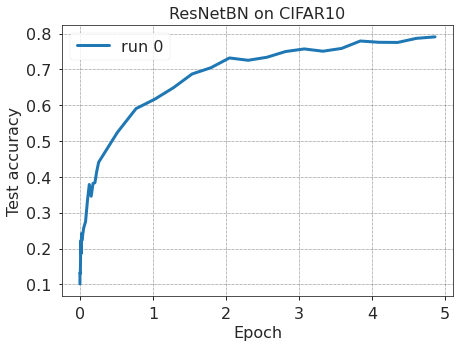

In [15]:
plt.figure(figsize = (7,5))
plt.title(model_name+" on "+dataset_choice,fontsize = 16)

for point_id in range(len(test_accs)):

  epochs_nice = []

  for i in range(len(its[point_id])):
    it_now = its[point_id][i]
    if it_now is None:
      epochs_nice.append(0)
    else:
      epochs_nice.append(it_now*128.0/50000.0)

  plt.plot(epochs_nice,test_accs[point_id],label = "run "+str(point_id),linewidth = 3)

plt.grid(True)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Epoch",fontsize = 16)
plt.ylabel("Test accuracy",fontsize = 16)

plt.legend(fontsize = 16)

plt.show()

# One-hot utils

In [16]:
#@title

@jax.vmap
def onehot_cross_entropy_loss(logits, onehot):
  return -jnp.sum(logits*onehot)

def onehot_compute_metrics(logits, onehot):
  loss = jnp.mean(onehot_cross_entropy_loss(logits, onehot))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(onehot, -1))
  return {'loss': loss, 'accuracy': accuracy}

def onehot_normal_loss(params, batch, ensemble_set_of_params = None):

  if ensemble_set_of_params is None: #the normal single params
    logits = jax.nn.log_softmax(model_to_use.call(params, batch['image']))
  else: #ensemble
    logits_list = []
    for params_now in ensemble_set_of_params:
      logits_list.append(jax.nn.log_softmax(model_to_use.call(params_now, batch['image'])))
    logits = jnp.mean(jnp.stack(logits_list,axis=0),axis=0)

  loss = jnp.mean(onehot_cross_entropy_loss(logits, batch['onehot']))

  return loss

def onehot_normal_accuracy(params,batch,ensemble_set_of_params = None):

  if ensemble_set_of_params is None: #the normal single params
    logits = jax.nn.log_softmax(model_to_use.call(params, batch['image']))
  else: #ensemble
    logits_list = []
    for params_now in ensemble_set_of_params:
      logits_list.append(jax.nn.log_softmax(model_to_use.call(params_now, batch['image'])))
    logits = jnp.mean(jnp.stack(logits_list,axis=0),axis=0)

  return jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(batch['onehot'],axis=-1))


# Cutting plane fns

In [17]:
#within plane params into an image
@jax.jit
def theta_to_image(theta,M,X0):
  return (jnp.matmul(theta,M)).reshape([-1,32,32,3]) + X0.reshape([-1,32,32,3])

#within plane params into a loss via an image fed into a NN
@jax.jit
def theta_to_loss(theta,M,X0,onehot_target,params, ensemble_set_of_params = None):
  return onehot_normal_loss(params,{"image": theta_to_image(theta,M,X0), "onehot": onehot_target},ensemble_set_of_params)

#the gradient of the within plane params based on the loss
def give_me_theta_grad(theta,M,X0,onehot_target,params, ensemble_set_of_params = None):
  theta_loss_prefilled = lambda theta_now: theta_to_loss(theta_now,M,X0,onehot_target, params, ensemble_set_of_params)
  return jax.grad(theta_loss_prefilled)(theta)


# Make projection matrix

In [18]:
def make_bases(d,D,k_nonzero = None,enforce_no_overlap_if_possible = True):

  M_random = onp.random.normal(loc=0.0,scale=1.0,size=(d,D))

  if k_nonzero is None: #no conditions on axis alignment
    M_now = M_random
  else:
    M_now = onp.zeros((d,D))

    if ((k_nonzero*d <= D) and (enforce_no_overlap_if_possible == True)):
      ids_flat = onp.random.choice(range(D),(k_nonzero*d),replace=False)
      ids_shaped = ids_flat.reshape([d,k_nonzero])
    elif ((k_nonzero*d <= D) and (enforce_no_overlap_if_possible == False)):
      ids_flat = onp.random.choice(range(D),(k_nonzero*d),replace=True)
      ids_shaped = ids_flat.reshape([d,k_nonzero])
    else:
      ids_flat = onp.random.choice(range(D),(k_nonzero*d),replace=True)
      ids_shaped = ids_flat.reshape([d,k_nonzero])

    for i in range(d):
      M_now[i,ids_shaped[i]] = M_random[i,ids_shaped[i]]
  
  #normalization to unit length of each basis vector
  M_now = M_now / onp.linalg.norm(M_now,axis=-1,keepdims=True)  

  return M_now

# Encapsulation of plane optimization

In [32]:
from jax import ops
from jax import lax

def fast_optimize_on_plane(
    LR = 5e-2, #the learning rate on the cutting plane
    plane_steps = 100, #the max number of gradient descent steps
    classes=10, #the number of classes
    low_loss_stopping_threshold = 1e-2, #stops optimization when loss is low enough 
    std_loss_stopping_threshold = 1e-3, #stops optimization when loss doesn't change enough
    ):
  
  def optimize_fn(
      M, #bases of the projection plane
      X0, #the point defining the projection plane
      Y, #the target labels for optimization
      params, #networks params for single network
      ensemble_set_of_params = None #list of network params if ensemble is used
      ):
    
    #class targets
    onehot_target = jnp.zeros((classes))
    onehot_target = ops.index_update(onehot_target, jnp.array(Y), 1.0/float(len(Y)))
    onehot_target = onehot_target.reshape([1,-1])
  
    #defining Adam params
    beta_1=0.9
    beta_2=0.999
    epsilon=1e-07

    d = M.shape[0] #plane dimension

    #adam vectors
    vector_mass = jnp.zeros((1, d))
    vector_velocity = jnp.zeros((1, d))

    #storing results
    losses_buffer = jnp.zeros((plane_steps,))
    probs_buffer = jnp.zeros((plane_steps, classes))
    thetas_buffer = jnp.zeros((plane_steps,))

    #starting off
    theta = jnp.zeros((1, d))  

    target_loss = jnp.log(len(class_targets))

    def cond_fn(state):
      i, theta, mass, velocity, losses, probs, thetas = state
      cond = ((i < plane_steps) & 
              (jnp.abs(losses[i - 1] - target_loss) > low_loss_stopping_threshold))
      look_back = 5
      look_back_buff = lax.dynamic_slice(losses, (i - look_back,), (look_back,))
      cond = cond & (jnp.abs(jnp.std(look_back_buff)) > std_loss_stopping_threshold)
      return (i <= 5) | cond

    def inner_fn(state):
      i, theta, mass, velocity, losses, probs, thetas = state

      g = give_me_theta_grad(theta, M, X0, onehot_target, params, ensemble_set_of_params)
      loss = theta_to_loss(theta, M, X0, onehot_target, params, ensemble_set_of_params)

      if ensemble_set_of_params is None: #the usual single model
        preds = jax.nn.softmax(
            model_to_use.call(params, theta_to_image(theta, M, X0)),
            axis=-1
            )
      else: #the ensembling mode
        preds_all = jnp.zeros((1,classes))
        for params_now in ensemble_set_of_params:
          preds_now = jax.nn.softmax(
            model_to_use.call(params_now, theta_to_image(theta, M, X0)),
            axis=-1
            )
          preds_all += preds_now
        preds = preds_all / float(len(ensemble_set_of_params))

      
      losses = ops.index_update(losses, i, loss)
      probs = ops.index_update(probs, i, preds[0])
      thetas = ops.index_update(thetas, i, jnp.linalg.norm(theta))

      mass = beta_1 * mass + (1.0 - beta_1) * g
      velocity = beta_2 * velocity + (1.0 - beta_2) * (g**2.0)

      hat_mass = mass / (1.0-beta_1)
      hat_velocity = velocity / (1.0-beta_2)

      #the update to params in the plane
      theta = theta - LR / (jnp.sqrt(hat_velocity) + epsilon) * hat_mass

      return i + 1, theta, mass, velocity, losses, probs, thetas

    state = (0, theta, vector_mass, vector_velocity, 
             losses_buffer, probs_buffer, thetas_buffer)
    state = lax.while_loop(cond_fn, inner_fn, state)

    i, _, _, _, losses_buffer, probs_buffer, thetas_buffer = state

    return state[0], losses_buffer, probs_buffer, thetas_buffer 
  return optimize_fn

# Getting a train image

In [33]:
#getting a train image to start from that is NOT any of the target classes
def get_train_image(exclude_classes = [], classes = 10):

  if set(exclude_classes) != set(list(range(classes))):
    # print("selective")
    allowed = onp.ones((len(train_ds["label"]))).astype(onp.bool)
    for c in exclude_classes:
      class_bools = train_ds["label"] == c
      allowed = onp.logical_and(allowed,onp.logical_not(class_bools))
    id_selected = onp.random.choice(onp.array(range(len(train_ds["label"])))[allowed],(1))[0]
    
  else:
    # print("all allowed")
    allowed = onp.ones((len(train_ds["label"]))).astype(onp.bool)
    id_selected = onp.random.choice(onp.array(range(len(train_ds["label"])))[allowed],(1))[0]
  return train_ds["image"][id_selected]

# Plotter

In [34]:
#@title
from scipy.optimize import curve_fit

#empirical fit
def func(x, a, b, c, d):
    return a + b/(1.0+onp.exp(-(onp.log(x)-onp.log(c))/d))

def func2(x, a, b, c, d):
    return -onp.log(a + b/(1.0+onp.exp(-(onp.log(x)-onp.log(c))/d)))

def make_a_plot(storing_results,class_targets):

  #extracting data
  ds_collected = [qs[0] for qs in storing_results]
  ps_collected = [onp.max(onp.sum(qs[4][:,class_targets],axis=-1)) for qs in storing_results]
  losses_collected = [onp.min(qs[5][:]) for qs in storing_results]


  plt.figure(figsize = (2*6.5,5.5))

  plt.suptitle(model_name+" on "+dataset_choice+", target classes="+str(class_targets),fontsize = 20)

  plt.subplot(1,2,1)
  plt.title("Probabilities",fontsize = 18)

  #doing the probability fit
  try:
    p0 = [0.0,1.0,30.0,2.0]
    popt, pcov = curve_fit(func, ds_collected, ps_collected, p0 = p0)
    fit_done = True
  except:
    fit_done = False

  plt.semilogx()
  plt.scatter(ds_collected,ps_collected,marker = "o",color = "crimson",s = 60,label = "data c="+str(class_targets))

  ds_unique = list(sorted(list(set(ds_collected))))

  if fit_done == True:
    #adding the fit
    xs_fit = onp.linspace(onp.min(ds_unique),onp.max(ds_unique),10000)
    ys_fit = func(xs_fit,*popt)

    label = "Fit"

    plt.plot(xs_fit,ys_fit,linestyle = "--",color = "crimson",linewidth = 4,label = label)

    M_fns = 50
    all_fit_params = onp.random.multivariate_normal(mean = popt,cov = pcov, size=(M_fns))
    ys_fit_all = []
    for params in all_fit_params:
      ys_fit = func(xs_fit,*params)
      ys_fit_all.append(ys_fit)
    ys_fit_all = onp.array(ys_fit_all)

    plt.fill_between(xs_fit,onp.min(ys_fit_all,axis=0),onp.max(ys_fit_all,axis=0),color = "crimson",alpha = 0.3)

    #getting the distribution of crossing 50%
    min_ids = onp.argmin(onp.abs(onp.array(ys_fit_all) - 0.5),axis=-1)
    d_50_min = onp.min(xs_fit[min_ids])
    d_50_max = onp.max(xs_fit[min_ids])

    mean_str = "{:.1f}".format((d_50_min+d_50_max)/2.0)
    error_str = "{:.1f}".format((d_50_max-d_50_min)/2.0)
    label = "$d^*_{50\%}="+mean_str+"\pm"+error_str+"$"
    plt.fill_between([d_50_min,d_50_max],[0.0,0.0],[1.0,1.0],color = "orange",alpha = 0.5,label = label)

  plt.xlim([0,3072])



  plt.xlabel("Cutting plane dimension",fontsize = 16)
  plt.ylabel("Max probability reached",fontsize = 16)

  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(fontsize = 16)


  plt.subplot(1,2,2)
  plt.title("Losses",fontsize = 18)

  #doing the probability fit
  try:
    p0 = [0.0,1.0,30.0,2.0]
    popt, pcov = curve_fit(func2, ds_collected, losses_collected, p0 = p0)
    fit_done = True
  except:
    fit_done = False

  plt.semilogx()
  plt.scatter(ds_collected,losses_collected,marker = "o",color = "navy",s = 60,label = "data c="+str(class_targets))


  ds_unique = list(sorted(list(set(ds_collected))))


  if fit_done == True:
    #adding the fit
    xs_fit = onp.linspace(onp.min(ds_unique),onp.max(ds_unique),10000)
    ys_fit = func2(xs_fit,*popt)

    label = "Fit"

    plt.plot(xs_fit,ys_fit,linestyle = "--",color = "navy",linewidth = 4,label = label)

    M_fns = 50
    all_fit_params = onp.random.multivariate_normal(mean = popt,cov = pcov, size=(M_fns))
    ys_fit_all = []
    for params in all_fit_params:
      ys_fit = func2(xs_fit,*params)
      ys_fit_all.append(ys_fit)
    ys_fit_all = onp.array(ys_fit_all)

    plt.fill_between(xs_fit,onp.min(ys_fit_all,axis=0),onp.max(ys_fit_all,axis=0),color = "navy",alpha = 0.3)

    #getting the distribution of crossing 0.1 loss
    min_ids = onp.argmin(onp.abs(onp.array(ys_fit_all) - 0.3),axis=-1)
    d_50_min = onp.min(xs_fit[min_ids])
    d_50_max = onp.max(xs_fit[min_ids])

  plt.xlim([0,3072])


  plt.xlabel("Cutting plane dimension",fontsize = 16)
  plt.ylabel("Min loss reached",fontsize = 16)

  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(fontsize = 16)

  # plt.tight_layout()

  plt.show()

# Cutting plane experiment

## Experiment settings

In [35]:
D_input = 32*32*3 #the input space dimension, 32*32*3 for CIFAR-10

#choosing the latest trained params from the first run
params_to_use = params_collected_by_iteration[0][-1][1]

#for ensembling

#turns off ensembling
ensemble_set_of_params = None
ensemble_model_ids = []

#for ensembling, uncomment the following
# ensemble_model_ids = [0,1,2,3,4,5,6,7,8,9] #models chosen into the ensemble
# ensemble_set_of_params = [params_collected_by_iteration[i][-1][1] for i in ensemble_model_ids]
# print("Ensembling "+str(ensemble_model_ids))

LR = 5e-2 #plane LR
plane_steps = 300 #max number of steps

#type of hyperplanes 
plane_type = "random" #no axis alignemnt
# plane_type = 1 #axis aligned vectors, choose between 1 and D_input

if plane_type == "random":
  plane_nonzero_per_vector = None
else:
  plane_nonzero_per_vector = int(plane_type)

print("Plane type "+str(plane_type)+" => non-zero="+str(plane_nonzero_per_vector))


Plane type random => non-zero=None


## Sweep definition

In [36]:
reps = 5 #number of repetitions of each experiment

#the cutting plane dimensions to explore
ds_to_explore = [1,3,5,10,15,30,50,75,100,200,300,500,1000,3072] 

# which classes to optimize towards
class_targets_to_explore = [
  [0],[1],[2],[3],[4],[5],[6],[7],[8],[9],
  #[0,1,2,3], #an example of an in-between-class region
]

## Cutting plane experimental loop (<5 min on a free Google Colab GPU)

Starting cs=[0]
onehot_target [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.06690892]->0.06698882 loss=2.7032294 stop step=6 dt=3.5480728149414062
d=1 rep=1/5 p=[0.0805103]->0.09514844 loss=2.352317 stop step=29 dt=0.12062954902648926
d=1 rep=2/5 p=[0.07188895]->0.10555732 loss=2.248501 stop step=49 dt=0.15297794342041016
d=1 rep=3/5 p=[0.06686097]->0.0671145 loss=2.701355 stop step=7 dt=0.07294344902038574
d=1 rep=4/5 p=[0.16186832]->0.17203231 loss=1.760073 stop step=19 dt=0.09569597244262695
d=3 rep=0/5 p=[0.10929667]->0.12574412 loss=2.0735064 stop step=37 dt=0.13172245025634766
d=3 rep=1/5 p=[0.08490105]->0.08696527 loss=2.4422464 stop step=15 dt=0.09372115135192871
d=3 rep=2/5 p=[0.10145898]->0.16633439 loss=1.793755 stop step=55 dt=0.16211748123168945
d=3 rep=3/5 p=[0.10951453]->0.111434504 loss=2.1943183 stop step=13 dt=0.08699893951416016
d=3 rep=4/5 p=[0.12411583]->0.12543285 loss=2.0759847 stop step=11 dt=0.08525943756103516
d=5 rep=0/5 p=[0.08185484]->0.10499298 loss=2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


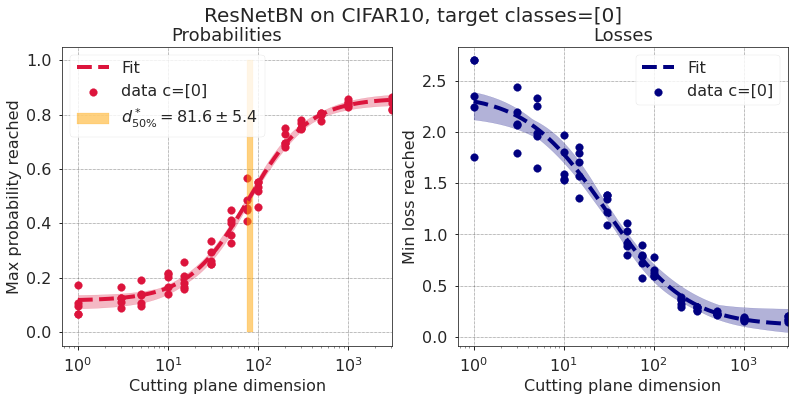

Time remaining approximately 151 seconds.
Starting cs=[1]
onehot_target [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.05665278]->0.061883744 loss=2.7824976 stop step=27 dt=0.1210165023803711
d=1 rep=1/5 p=[0.04256991]->0.04312315 loss=3.1436954 stop step=10 dt=0.08405089378356934
d=1 rep=2/5 p=[0.0399353]->0.04601761 loss=3.078731 stop step=23 dt=0.10768842697143555
d=1 rep=3/5 p=[0.04697624]->0.049136598 loss=3.0131512 stop step=17 dt=0.09600520133972168
d=1 rep=4/5 p=[0.04728096]->0.08332701 loss=2.4849825 stop step=101 dt=0.24697136878967285
d=3 rep=0/5 p=[0.04525312]->0.05774189 loss=2.8517723 stop step=28 dt=0.11731791496276855
d=3 rep=1/5 p=[0.02892812]->0.032104697 loss=3.438753 stop step=19 dt=0.10456633567810059
d=3 rep=2/5 p=[0.05337483]->0.0550292 loss=2.8998914 stop step=10 dt=0.08197832107543945
d=3 rep=3/5 p=[0.06209037]->0.079085484 loss=2.537226 stop step=29 dt=0.1171271800994873
d=3 rep=4/5 p=[0.04725688]->0.06282536 loss=2.7673965 stop step=28 dt=0.11214852333068

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


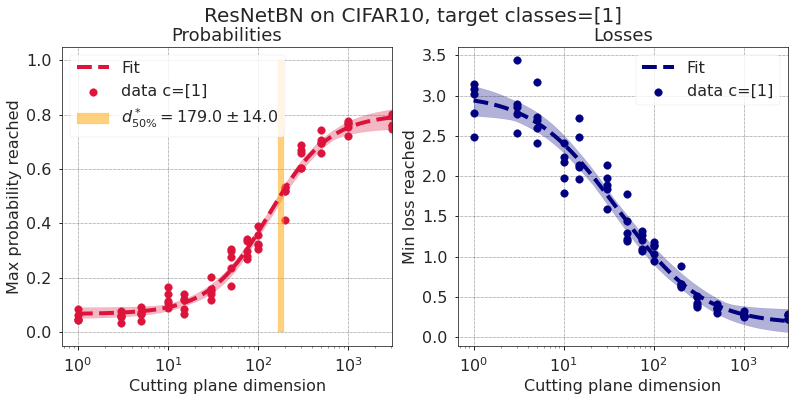

Time remaining approximately 115 seconds.
Starting cs=[2]
onehot_target [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.10898661]->0.11960722 loss=2.123542 stop step=46 dt=0.15324687957763672
d=1 rep=1/5 p=[0.06188304]->0.09481355 loss=2.355843 stop step=43 dt=0.142319917678833
d=1 rep=2/5 p=[0.08479838]->0.0856052 loss=2.4580092 stop step=8 dt=0.07761764526367188
d=1 rep=3/5 p=[0.10500173]->0.1172527 loss=2.1434238 stop step=32 dt=0.1224374771118164
d=1 rep=4/5 p=[0.11753003]->0.11801155 loss=2.1369727 stop step=6 dt=0.07669496536254883
d=3 rep=0/5 p=[0.10643838]->0.10870185 loss=2.2191465 stop step=19 dt=0.09836697578430176
d=3 rep=1/5 p=[0.17605545]->0.17691956 loss=1.7320601 stop step=6 dt=0.07413840293884277
d=3 rep=2/5 p=[0.14425075]->0.1662946 loss=1.7939943 stop step=23 dt=0.1035301685333252
d=3 rep=3/5 p=[0.1008184]->0.13432641 loss=2.0074825 stop step=32 dt=0.12225580215454102
d=3 rep=4/5 p=[0.11198219]->0.17371377 loss=1.7503464 stop step=79 dt=0.2085418701171875
d=5 rep=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


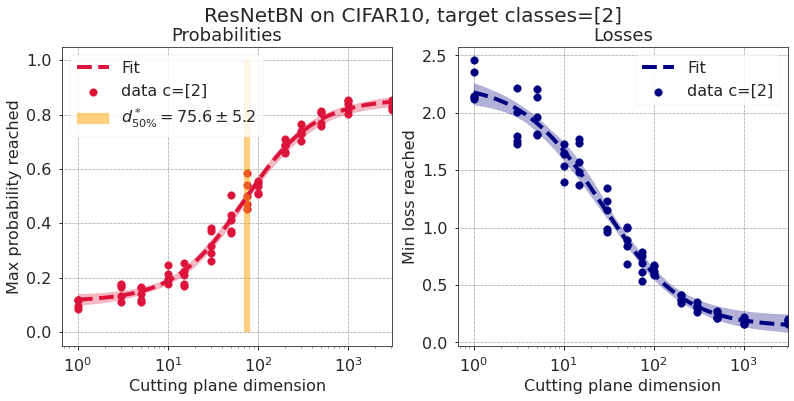

Time remaining approximately 82 seconds.
Starting cs=[3]
onehot_target [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.37041503]->0.37792566 loss=0.97305775 stop step=14 dt=0.09304022789001465
d=1 rep=1/5 p=[0.28427356]->0.28780758 loss=1.2454631 stop step=8 dt=0.07422351837158203
d=1 rep=2/5 p=[0.29825565]->0.30016124 loss=1.2034354 stop step=9 dt=0.07599043846130371
d=1 rep=3/5 p=[0.2640734]->0.27767956 loss=1.2812874 stop step=17 dt=0.0957174301147461
d=1 rep=4/5 p=[0.33511004]->0.33546084 loss=1.0922501 stop step=6 dt=0.07558560371398926
d=3 rep=0/5 p=[0.3499053]->0.38081735 loss=0.9654354 stop step=27 dt=0.11152100563049316
d=3 rep=1/5 p=[0.33489186]->0.35920125 loss=1.0238724 stop step=24 dt=0.10457897186279297
d=3 rep=2/5 p=[0.34569302]->0.3628809 loss=1.0136806 stop step=20 dt=0.0968315601348877
d=3 rep=3/5 p=[0.38374135]->0.3956414 loss=0.92724705 stop step=19 dt=0.10401129722595215
d=3 rep=4/5 p=[0.32473013]->0.34682128 loss=1.0589457 stop step=17 dt=0.09592628479003906
d=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


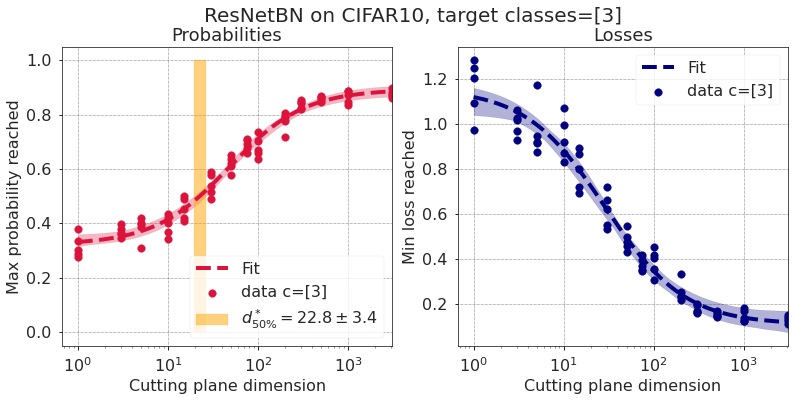

Time remaining approximately 59 seconds.
Starting cs=[4]
onehot_target [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.04936185]->0.050306305 loss=2.989625 stop step=11 dt=0.08481836318969727
d=1 rep=1/5 p=[0.03995493]->0.043695502 loss=3.13051 stop step=19 dt=0.09358453750610352
d=1 rep=2/5 p=[0.06505322]->0.0729456 loss=2.618041 stop step=33 dt=0.12338113784790039
d=1 rep=3/5 p=[0.06044957]->0.084228195 loss=2.4742255 stop step=68 dt=0.17985296249389648
d=1 rep=4/5 p=[0.04048422]->0.040537212 loss=3.205535 stop step=6 dt=0.06815409660339355
d=3 rep=0/5 p=[0.06195283]->0.07503175 loss=2.589844 stop step=42 dt=0.13871002197265625
d=3 rep=1/5 p=[0.04321782]->0.1080171 loss=2.2254658 stop step=119 dt=0.279400110244751
d=3 rep=2/5 p=[0.02871884]->0.028902551 loss=3.5438254 stop step=6 dt=0.06849193572998047
d=3 rep=3/5 p=[0.04926212]->0.07873416 loss=2.5416782 stop step=36 dt=0.12491846084594727
d=3 rep=4/5 p=[0.06314357]->0.067740954 loss=2.6920643 stop step=20 dt=0.0945272445678711
d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


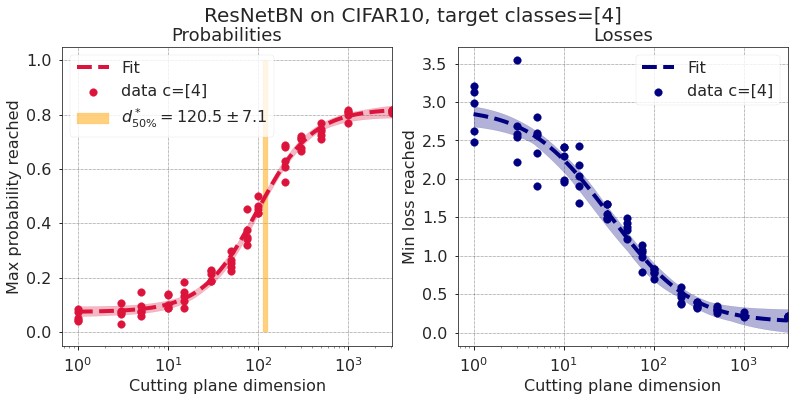

Time remaining approximately 46 seconds.
Starting cs=[5]
onehot_target [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
d=1 rep=0/5 p=[0.16239983]->0.1755836 loss=1.7396399 stop step=25 dt=0.1083672046661377
d=1 rep=1/5 p=[0.15693587]->0.15695909 loss=1.85177 stop step=6 dt=0.06800627708435059
d=1 rep=2/5 p=[0.14833558]->0.14842029 loss=1.9077072 stop step=6 dt=0.06877541542053223
d=1 rep=3/5 p=[0.15342924]->0.20413592 loss=1.5889692 stop step=44 dt=0.13914704322814941
d=1 rep=4/5 p=[0.17269649]->0.17518955 loss=1.7418866 stop step=12 dt=0.07908082008361816
d=3 rep=0/5 p=[0.11814452]->0.17704593 loss=1.7313461 stop step=68 dt=0.20097661018371582
d=3 rep=1/5 p=[0.18586484]->0.19147375 loss=1.6530045 stop step=9 dt=0.07439661026000977
d=3 rep=2/5 p=[0.12910557]->0.18857913 loss=1.6682374 stop step=61 dt=0.17629289627075195
d=3 rep=3/5 p=[0.1526168]->0.22355926 loss=1.4980787 stop step=47 dt=0.14843034744262695
d=3 rep=4/5 p=[0.10221298]->0.16335781 loss=1.8118123 stop step=53 dt=0.17126035690307617
d=5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


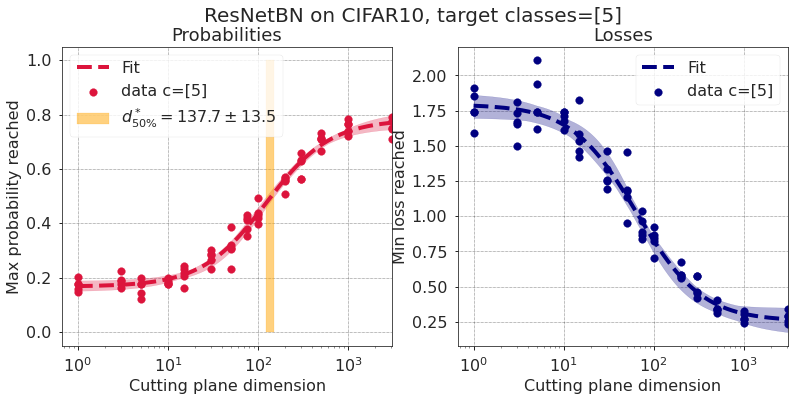

Time remaining approximately 33 seconds.
Starting cs=[6]
onehot_target [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
d=1 rep=0/5 p=[0.05468618]->0.06700905 loss=2.7029276 stop step=53 dt=0.16073226928710938
d=1 rep=1/5 p=[0.06430215]->0.06492582 loss=2.73451 stop step=7 dt=0.0734097957611084
d=1 rep=2/5 p=[0.04835403]->0.048443176 loss=3.0273638 stop step=6 dt=0.06955099105834961
d=1 rep=3/5 p=[0.06203078]->0.063009985 loss=2.764462 stop step=15 dt=0.08603572845458984
d=1 rep=4/5 p=[0.05457729]->0.05476005 loss=2.9047942 stop step=10 dt=0.0760643482208252
d=3 rep=0/5 p=[0.07941904]->0.081150346 loss=2.5114517 stop step=10 dt=0.07859659194946289
d=3 rep=1/5 p=[0.1134657]->0.11516934 loss=2.1613517 stop step=11 dt=0.0811007022857666
d=3 rep=2/5 p=[0.07725412]->0.084015034 loss=2.4767594 stop step=15 dt=0.0899515151977539
d=3 rep=3/5 p=[0.08007064]->0.101948835 loss=2.2832842 stop step=28 dt=0.11185669898986816
d=3 rep=4/5 p=[0.0549221]->0.06779998 loss=2.6911933 stop step=41 dt=0.1349472999572754
d=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


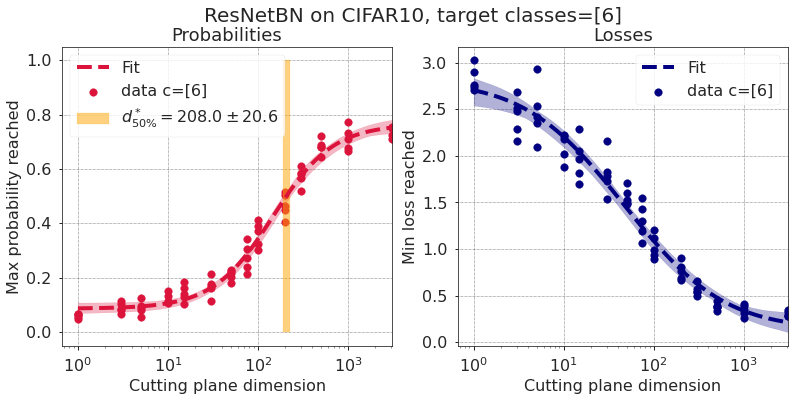

Time remaining approximately 23 seconds.
Starting cs=[7]
onehot_target [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
d=1 rep=0/5 p=[0.02728394]->0.027935527 loss=3.577856 stop step=13 dt=0.08958029747009277
d=1 rep=1/5 p=[0.02794436]->0.03020519 loss=3.4997416 stop step=23 dt=0.10139703750610352
d=1 rep=2/5 p=[0.03910613]->0.04715985 loss=3.0542123 stop step=37 dt=0.12498092651367188
d=1 rep=3/5 p=[0.04571998]->0.045738094 loss=3.0848238 stop step=6 dt=0.07186198234558105
d=1 rep=4/5 p=[0.03617657]->0.036187496 loss=3.3190417 stop step=6 dt=0.06994104385375977
d=3 rep=0/5 p=[0.03208838]->0.04915573 loss=3.0127618 stop step=68 dt=0.18336892127990723
d=3 rep=1/5 p=[0.03412043]->0.06423446 loss=2.7452154 stop step=129 dt=0.29538583755493164
d=3 rep=2/5 p=[0.04783864]->0.060014274 loss=2.8131728 stop step=27 dt=0.11682319641113281
d=3 rep=3/5 p=[0.02210764]->0.04172783 loss=3.1765869 stop step=61 dt=0.17145967483520508
d=3 rep=4/5 p=[0.02966932]->0.03237299 loss=3.430431 stop step=9 dt=0.0762844085693

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


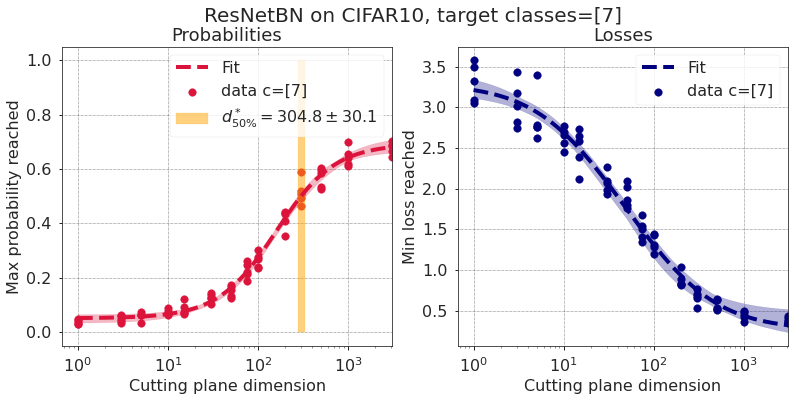

Time remaining approximately 14 seconds.
Starting cs=[8]
onehot_target [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
d=1 rep=0/5 p=[0.03845277]->0.045193274 loss=3.096807 stop step=21 dt=0.10331916809082031
d=1 rep=1/5 p=[0.02063804]->0.020702649 loss=3.8774936 stop step=6 dt=0.06884646415710449
d=1 rep=2/5 p=[0.02672402]->0.030602213 loss=3.486683 stop step=25 dt=0.10210227966308594
d=1 rep=3/5 p=[0.04753072]->0.052019395 loss=2.9561386 stop step=16 dt=0.08669590950012207
d=1 rep=4/5 p=[0.0387133]->0.0432909 loss=3.139813 stop step=23 dt=0.09684395790100098
d=3 rep=0/5 p=[0.04620517]->0.049607683 loss=3.0036097 stop step=18 dt=0.08907103538513184
d=3 rep=1/5 p=[0.05978415]->0.06638262 loss=2.71232 stop step=32 dt=0.11538338661193848
d=3 rep=2/5 p=[0.03670237]->0.037613254 loss=3.2803988 stop step=13 dt=0.08305907249450684
d=3 rep=3/5 p=[0.02764398]->0.03319019 loss=3.405501 stop step=25 dt=0.1061544418334961
d=3 rep=4/5 p=[0.04166455]->0.042707216 loss=3.1533875 stop step=13 dt=0.0851402282714843

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


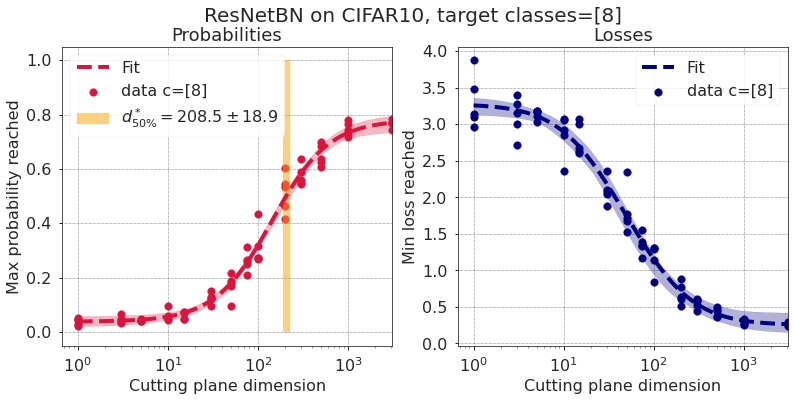

Time remaining approximately 6 seconds.
Starting cs=[9]
onehot_target [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
d=1 rep=0/5 p=[0.0303627]->0.03378742 loss=3.3876667 stop step=30 dt=0.1161644458770752
d=1 rep=1/5 p=[0.05550969]->0.066076316 loss=2.716945 stop step=44 dt=0.1394350528717041
d=1 rep=2/5 p=[0.07015182]->0.07200331 loss=2.6310432 stop step=21 dt=0.09843635559082031
d=1 rep=3/5 p=[0.04010484]->0.042108 loss=3.1675177 stop step=19 dt=0.09189677238464355
d=1 rep=4/5 p=[0.07068595]->0.07967006 loss=2.5298615 stop step=21 dt=0.09404397010803223
d=3 rep=0/5 p=[0.0774233]->0.08099301 loss=2.5133924 stop step=22 dt=0.09653544425964355
d=3 rep=1/5 p=[0.0420694]->0.048123486 loss=3.033985 stop step=34 dt=0.12036442756652832
d=3 rep=2/5 p=[0.05471429]->0.08878332 loss=2.4215565 stop step=36 dt=0.12273907661437988
d=3 rep=3/5 p=[0.04078219]->0.08421892 loss=2.4743357 stop step=60 dt=0.16620326042175293
d=3 rep=4/5 p=[0.07583021]->0.08165754 loss=2.5052211 stop step=22 dt=0.09914731979370117
d=5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


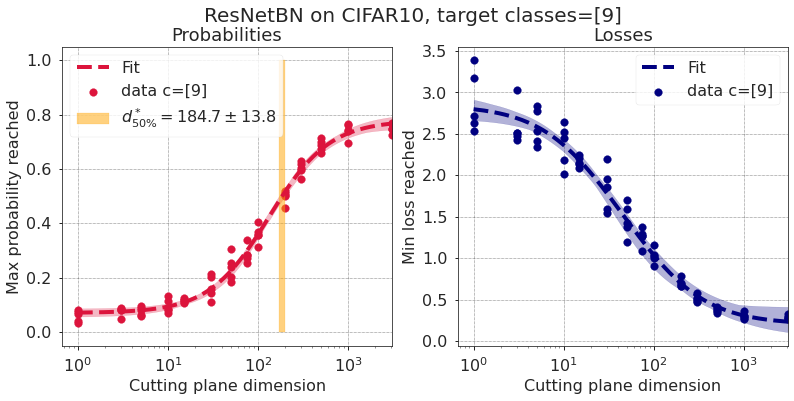

Time remaining approximately 0 seconds.


In [37]:
#the fast fn compilation
opt_fn = jax.jit(fast_optimize_on_plane(LR, plane_steps, classes))

ts = []

storing_all_experiments= []
for class_targets in class_targets_to_explore:
  t1 = time.time()

  print("Starting cs="+str(class_targets))

  #class targets
  # class_targets = [1]
  onehot_target = onp.zeros((classes))
  onehot_target[class_targets] = 1.0/float(len(class_targets))
  onehot_target = onehot_target.reshape([1,-1])
  print("onehot_target",onehot_target)

  onehot_target = jnp.array(onehot_target)

  storing_results = []

  for d in ds_to_explore:
    for rep in range(reps):

      t1 = time.time()

      M_now = make_bases(d,D_input,plane_nonzero_per_vector,True)

      #making it constant dimension to prevent recompilation of the FN 
      #which infers dimensions dynamically
      M_remaining_zeros = onp.zeros((D_input-d,D_input))
      M_now = onp.concatenate([M_now,M_remaining_zeros],axis=0)

      #offset of the plane
      X0 = get_train_image(exclude_classes=class_targets)

      i_final, losses_list, probs_list, thetas_list = opt_fn(M_now, X0, class_targets, params_to_use, ensemble_set_of_params)
      losses_list.block_until_ready()
      probs_list.block_until_ready()
      thetas_list.block_until_ready()

      t2 = time.time()
      
      print("d="+str(d)+
            " rep="+str(rep)+"/"+str(reps)+
            " p="+str(probs_list[0,class_targets])+"->"+str(onp.max(probs_list[:i_final,class_targets]))+
            " loss="+str(onp.min(losses_list[:i_final]))+
            " stop step="+str(len(losses_list[:i_final]))+
            " dt="+str(t2-t1)
            )

      #storing the results
      storing_results.append(
        (d,rep,onp.max(probs_list[:i_final,class_targets]),onp.min(losses_list[:i_final]),probs_list[:i_final],losses_list[:i_final],thetas_list[:i_final])
      )

  #plotting on the fly
  make_a_plot(storing_results,class_targets)

  storing_all_experiments.append(storing_results)

  #countdown
  t2 = time.time()
  ts.append(t2-t1)
  t_rem = onp.mean(ts)*len(class_targets_to_explore) - onp.sum(ts)
  print("Time remaining approximately "+str(int(t_rem))+" seconds.")


# Summary plot for all classes

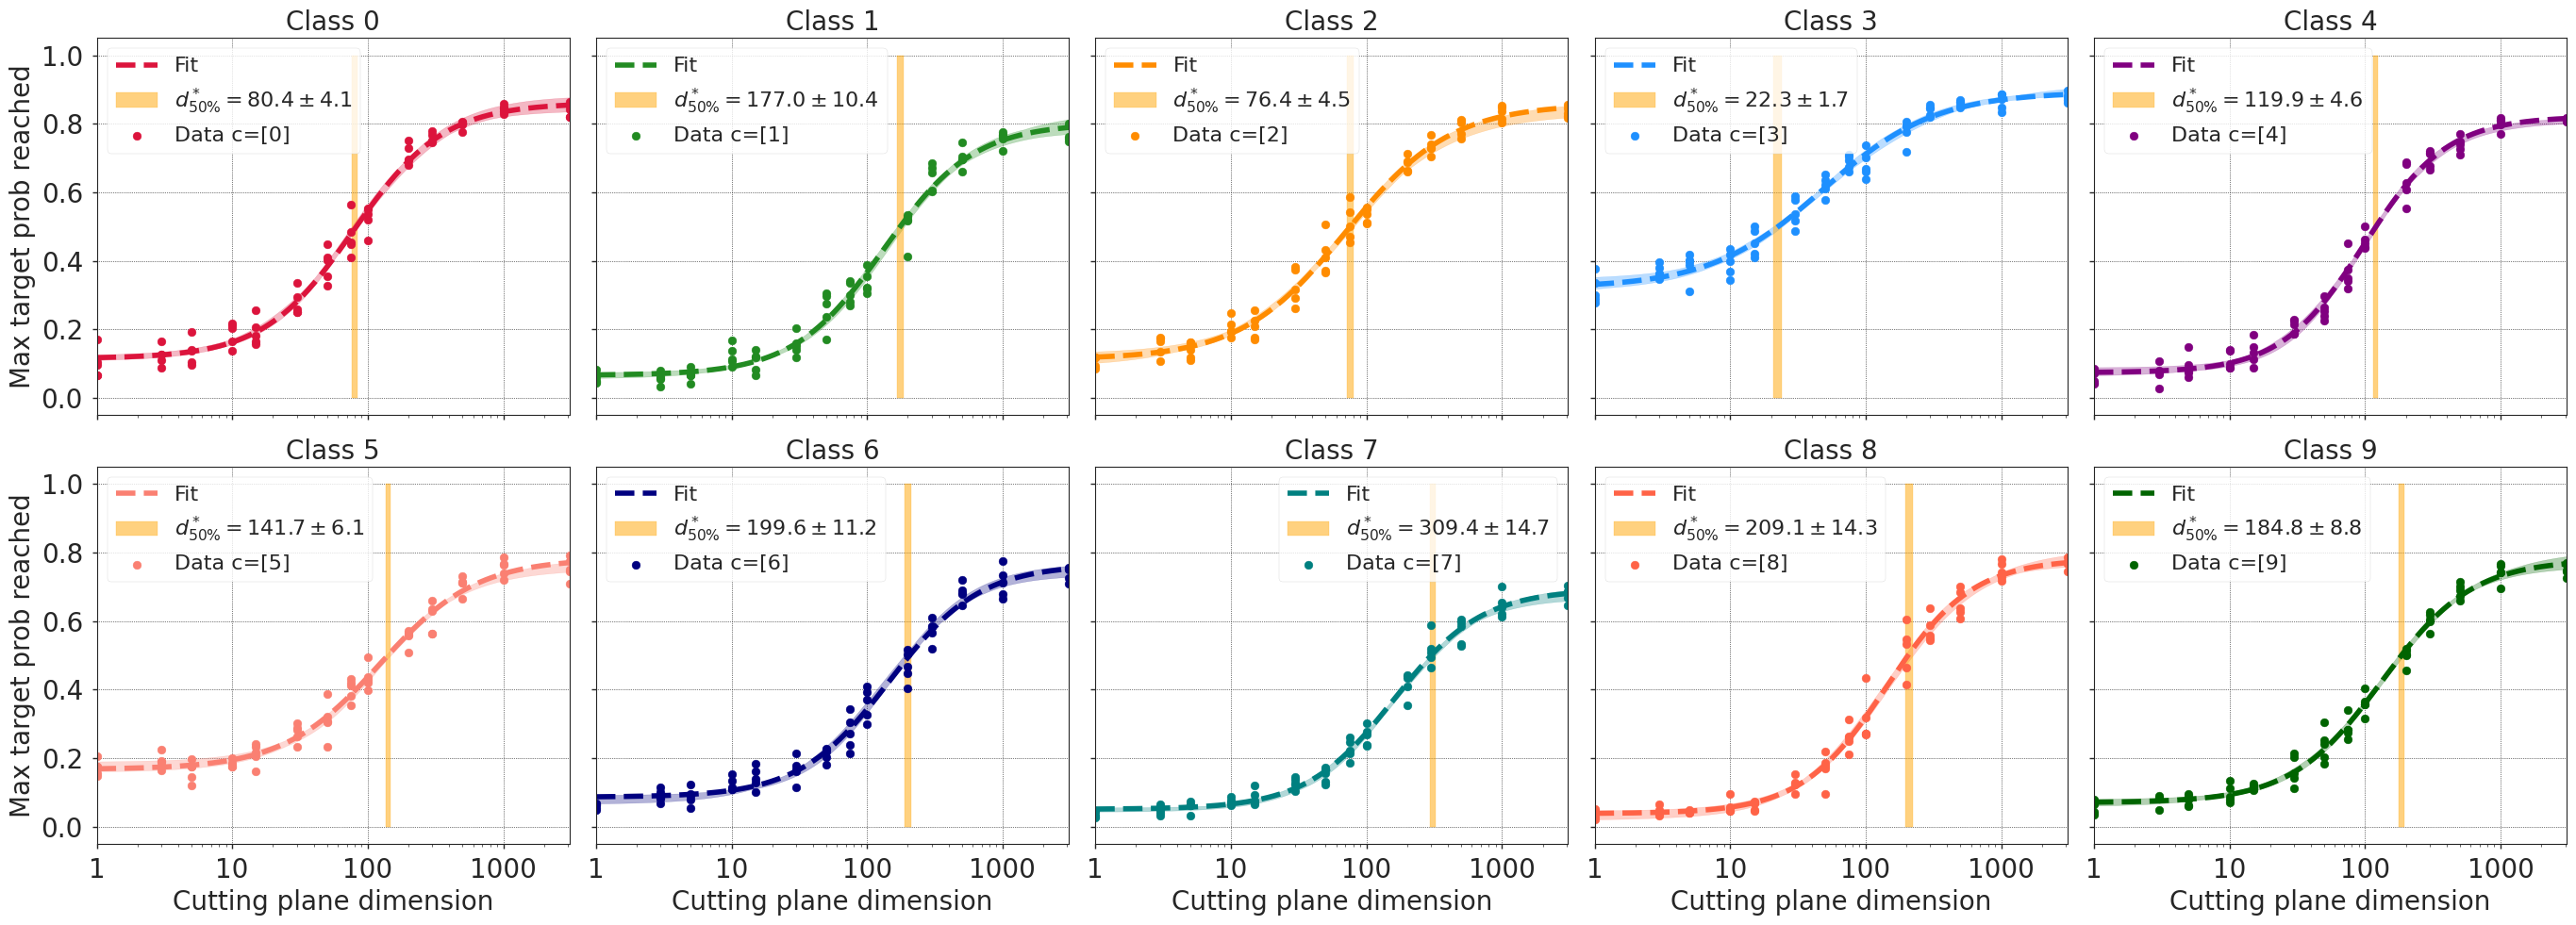

In [38]:
per_row = 5
rows = int(onp.ceil(float(len(class_targets_to_explore)) / float(per_row)))

from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a + b/(1.0+onp.exp(-(onp.log(x)-onp.log(c))/d))

plt.figure(figsize = (5.5*per_row,5*rows),dpi = 100)

for i in range(len(class_targets_to_explore)):

  plt.subplot(rows,per_row,i+1)


  storing_results = storing_all_experiments[i]
  class_targets = class_targets_to_explore[i]

  ds_collected = [qs[0] for qs in storing_results]
  ps_collected = [onp.max(onp.mean(qs[4][:,class_targets],axis=-1)) for qs in storing_results]
  
  ds_unique = list(sorted(list(set(ds_collected))))
  vals_collected = [[] for _ in ds_unique]
  for j,d_now in enumerate(ds_unique):
    vals_collected[j] = list(onp.array(ps_collected)[onp.array(ds_collected) == d_now])

  means = onp.mean(onp.array(vals_collected),axis=1)
  errors = onp.std(onp.array(vals_collected),axis=1)

  #fitting
  try:
    # popt, pcov = curve_fit(func, ds_unique, means, sigma=errors)
    p0 = [0.1,1.0,50,2.0]
    popt, pcov = curve_fit(func, ds_collected, ps_collected, p0 = p0)
    fit_done = True

    d_mid = popt[2]
    d_mid_error = onp.sqrt(pcov[2,2]) 
  except:
    fit_done = False

  plt.semilogx()

  colors = ["crimson","forestgreen","darkorange","dodgerblue","purple","salmon","navy","teal","tomato","darkgreen"]
  color = colors[i % len(colors)]

  if fit_done == True:
    #adding the fit
    xs_fit = onp.linspace(onp.min(ds_unique),onp.max(ds_unique),10000)
    ys_fit = func(xs_fit,*popt)

    label = "$d^*="+str(d_mid)[:4]+"\pm"+str(d_mid_error)[:4]+"$"
    label = "Fit"

    plt.plot(xs_fit,ys_fit,linestyle = "--",color = color,linewidth = 4,label = label)

    M_fns = 10
    all_fit_params = onp.random.multivariate_normal(mean = popt,cov = pcov, size=(M_fns))
    ys_fit_all = []
    for params in all_fit_params:
      ys_fit = func(xs_fit,*params)
      ys_fit_all.append(ys_fit)
    ys_fit_all = onp.array(ys_fit_all)

    plt.fill_between(xs_fit,onp.min(ys_fit_all,axis=0),onp.max(ys_fit_all,axis=0),color = color,alpha = 0.3)

    #getting the distribution of crossing 50%
    min_ids = onp.argmin(onp.abs(onp.array(ys_fit_all) - 0.5),axis=-1)
    d_50_min = onp.min(xs_fit[min_ids])
    d_50_max = onp.max(xs_fit[min_ids])

    mean_str = "{:.1f}".format((d_50_min+d_50_max)/2.0)
    error_str = "{:.1f}".format((d_50_max-d_50_min)/2.0)
    label = "$d^*_{50\%}="+mean_str+"\pm"+error_str+"$"
    plt.fill_between([d_50_min,d_50_max],[0.0,0.0],[1.0,1.0],color = "orange",alpha = 0.5,label = label)

  plt.xlim([1,3072])

  #data
  plt.scatter(ds_collected,ps_collected,marker = "o",color = color,s = 40,label = "Data c="+str(class_targets),alpha = 1.0)


  if i >= per_row*(rows-1): #bottom row x labels
    plt.xlabel("Cutting plane dimension",fontsize = 20)
 
  if i % per_row == 0: #left column ylabels only
    plt.ylabel("Max target prob reached",fontsize = 20)

  ticks = [1,10,100,1000]
  if i >= per_row*(rows-1): #bottom row x labels 
    plt.xticks(ticks=ticks,labels=ticks,fontsize = 20)
  else:
    plt.xticks(ticks=ticks,labels=[],fontsize = 20)

  ticks = [0.0,0.2,0.4,0.6,0.8,1.0]
  if i % per_row == 0: #left column ylabels only
    plt.yticks(ticks=ticks,labels=ticks,fontsize = 20)
  else:
    plt.yticks(ticks=ticks,labels=[],fontsize = 20)

  plt.title("Class "+str(class_targets[0]),fontsize = 20)

  plt.legend(fontsize = 16)

plt.tight_layout()


plt.show()
